In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')


#!pip install -U tensorflow==2.10
#!pip install -U tensorflow==2.9.2
import numpy as np
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split


!pip install transformers==4.37.2
#!pip install transformers==4.24
from transformers import (BertTokenizerFast, BertTokenizer, TFAutoModel,
                          TFBertForSequenceClassification, BertModel)
from transformers import TFBertModel
import IPython

#!pip install keras-tuner==1.0.4
!pip install keras-tuner
from keras_tuner.tuners import BayesianOptimization

import pickle
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.downloader

import matplotlib.pyplot as plt
import tensorflow as tf


Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 47.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.1
    Uninstalling transformers-4.41.1:
      Successfully uninstalled transformers-4.41.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [2]:
!gdown 119VdgSUbatmT5mDmpnwAtJQI-tewjYDg

Downloading...
From: https://drive.google.com/uc?id=119VdgSUbatmT5mDmpnwAtJQI-tewjYDg
To: /content/hasil_sentimen.csv
100% 1.27M/1.27M [00:00<00:00, 12.3MB/s]


In [3]:
sentimen = pd.read_csv('/content/hasil_sentimen.csv', index_col=0)
sentimen

,content,labeling
0,Saya sudah daftar dan ter verifikasi udh menga...,0
1,Aku kasih bintang 5 krn aku belum pernah meras...,0
2,Spesial tidak bisa masuk,0
3,Error Json Parse' padahal sudah update dan di ...,0
4,Negara +62 yg PNS nya digaji SDM nya ga punya ...,0
...,...,...
9450,"ga bisa login ""akun anda tidak di temukan /bel...",0
9451,"Kenapa aplikasi erros terus, trus ditulisnya b...",0
9452,sulit di buka,1
9453,"Pendaftaran sangat di persulit, Data saya suda...",0


## Preprocessing

In [4]:
def preProcessing1(tweet):
    # Convert to lower case
    tweet = tweet.lower()
    # remove unicode characters
    tweet = tweet.encode('ascii', 'ignore').decode()
    # Clean www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Clean @username
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')

    return tweet


_stopwords1 = set(stopwords.words('indonesian'))
_stopwrods2 = set(stopwords.words('english'))
additional_stopwords1 = ['saya', 'nya', 'saat',
                        'sih', 'deh', 'dll', 'nih', 'donk',
                        'dong', 'min', 'ny', 'si', 'eh', 'tu',
                        'mah', 'loh', 'aja', 'cm', 'blh', 'gt',
                         'knp', 'yg']
additional_stopwords2 = ['the', 'a', 'an', 'or', 'in']
new_stopwords = stopwords.words('indonesian') + additional_stopwords1 + additional_stopwords2 + stopwords.words('english')

def preProcessing2(text):
  # menghilangkan angka
  text = re.sub(r"\d+", "", text)
  # menghilangkan karakter spesial lain
  text = re.sub(r'[^\w\s]','',text)

  # tokenisasi
  tokens = re.findall(r'\b\w+\b', text)
  # menghilangkan stopword
  tokens = [token for token in tokens if token not in new_stopwords]

  # menggabungkan token
  text = ' '.join(tokens)

  return text


In [5]:
def cleaning(dataset):
  dataset['content_cleaned'] = dataset['content'].map(lambda x: preProcessing1(x))
  dataset['content_cleaned'] = dataset['content_cleaned'].map(lambda x: preProcessing2(x))
  dataset = dataset[dataset['content_cleaned'].apply(lambda x: len(x.split()) >= 3)].reset_index(drop=True)
  return dataset

In [6]:
sentimen = cleaning(sentimen)
sentimen #hasil preprocessing kedua

,content,labeling,content_cleaned
0,Saya sudah daftar dan ter verifikasi udh menga...,0,daftar ter verifikasi udh mengajukan bantuan j...
1,Aku kasih bintang 5 krn aku belum pernah meras...,0,kasih bintang krn seumur hidup ngk bantuan ban...
2,Error Json Parse' padahal sudah update dan di ...,0,error json parse update coba berkali
3,Negara +62 yg PNS nya digaji SDM nya ga punya ...,0,negara pns digaji sdm ga kwalitas website data...
4,Aku harap pendataannya sesuai dengan target,1,harap pendataannya sesuai target
...,...,...,...
8699,"Aplikasi gag jelas..., udh nunggu approval nya...",0,aplikasi gag udh nunggu approval pas udah appr...
8700,"ga bisa login ""akun anda tidak di temukan /bel...",0,ga login akun temukan aktivasi aktivasinya gim...
8701,"Kenapa aplikasi erros terus, trus ditulisnya b...",0,aplikasi erros trus ditulisnya bilang laporan ...
8702,"Pendaftaran sangat di persulit, Data saya suda...",0,pendaftaran persulit data seseuai ktp berlaku ...


In [7]:
for i in range(3):
  print("Sebelum: ", sentimen["content"][i])
  print("Sesudah: ", sentimen["content_cleaned"][i])

Sebelum:  Saya sudah daftar dan ter verifikasi udh mengajukan bantuan jg tinggal nunggu ,tapi pas masuk ke aplikasi kenapa selalu eror padahak data saya masih ada,tolong di perbaikin admin.
Sesudah:  daftar ter verifikasi udh mengajukan bantuan jg tinggal nunggu pas masuk aplikasi eror padahak data adatolong perbaikin admin
Sebelum:  Aku kasih bintang 5 krn aku belum pernah merasa kan dan seumur hidup aku ngk pernah dapat bantuan, bantuan berupa beras, berupa uang sedang kn tetangga banyak yg kaya2 tp toh merka sellallu dapat bantuan 😕🥺
Sesudah:  kasih bintang krn seumur hidup ngk bantuan bantuan beras uang kn tetangga kaya tp merka sellallu bantuan
Sebelum:  Error Json Parse' padahal sudah update dan di coba berkali2
Sesudah:  error json parse update coba berkali


# Representasi BERT

In [8]:
from tensorflow import keras
from transformers import AutoTokenizer, TFAutoModel
import IPython

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = TFAutoModel.from_pretrained("bert-base-multilingual-cased", trainable=False)

def tokenisasi(teks):
    encode_dict = bert_tokenizer(teks,
                                   add_special_tokens = True,
                                   max_length = 128,
                                   padding = 'max_length',
                                   truncation = True,
                                   return_attention_mask = True,
                                   return_tensors = 'tf',)

    tokenID = encode_dict['input_ids']
    attention_mask = encode_dict['attention_mask']

    return tokenID, attention_mask
    return tokenID

def create_input(data):
    tokenID, input_mask = [], []
    for teks in data:
        token, mask = tokenisasi(teks)
        tokenID.append(token)
        input_mask.append(mask)

    return [np.asarray(tokenID, dtype=np.int32).reshape(-1, 128),
            np.asarray(input_mask, dtype=np.int32).reshape(-1, 128)]



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [9]:
train_data = create_input(sentimen['content_cleaned'])[0]
train_data

array([[   101, 102714,  12718, ...,      0,      0,      0],
       [   101,  14399,  13187, ...,      0,      0,      0],
       [   101,  34046,    178, ...,      0,      0,      0],
       ...,
       [   101, 110720,  10163, ...,      0,      0,      0],
       [   101,  66558,  10229, ...,      0,      0,      0],
       [   101,  12718,  10229, ...,      0,      0,      0]], dtype=int32)

# Model EFCM

In [10]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(train_data)

In [11]:
#!gdown 1wO--Xq6Xv1QhYGrIcgawh4uyg0W21sKJ

In [12]:
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/MyDrive/Dataset TK2/FCMeans")

In [13]:
# Proses data per iterasi
total_data = sentimen['content_cleaned'].shape[0]  # Jumlah total data
batch_size = 256 # Jumlah data per iterasi
num_iterations = int(np.ceil(total_data / batch_size))  # Jumlah iterasi yang diperlukan

output = []  # Variabel untuk menyimpan hasil

for i in range(num_iterations):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, total_data)
    batch_data = sentimen['content_cleaned'].iloc[start_idx:end_idx].to_numpy()

    seq_words = create_input(batch_data)
    bert_emb = bert_model(seq_words)[1]
    output.append(bert_emb)

output = np.concatenate(output, axis=0)

output_shape = output.shape
print("Output shape:", output_shape)

Output shape: (8704, 768)


## Model FCMeans

In [14]:
"""
fcmeans.py : Fuzzy C-means clustering algorithm.
"""
import numpy as np
from scipy.spatial.distance import cdist


def _fcmeans0(data, u_old, c, m):
    """
    Single step in generic fuzzy c-means clustering algorithm.

    Modified from Ross, Fuzzy Logic w/Engineering Applications (2010),
    pages 352-353, equations 10.28 - 10.35.

    Parameters inherited from fcmeans()
    """
    # Normalizing, then eliminating any potential zero values.
    u_old /= np.ones((c, 1)).dot(np.atleast_2d(u_old.sum(axis=0)))
    u_old = np.fmax(u_old, np.finfo(np.float64).eps)

    um = u_old ** m

    # Calculate cluster centers
    data = data.T
    cntr = um.dot(data) / (np.ones((data.shape[1],1)).dot(np.atleast_2d(um.sum(axis=1))).T)

    d = _distance(data, cntr)
    d = np.fmax(d, np.finfo(np.float64).eps)

    jm = (um * d ** 2).sum()

    u = d ** (- 2. / (m - 1))
    u /= np.ones((c, 1)).dot(np.atleast_2d(u.sum(axis=0)))

    return cntr, u, jm, d


def _distance(data, centers):
    """
    Euclidean distance from each point to each cluster center.

    Parameters
    ----------
    data : 2d array (N x Q)
        Data to be analyzed. There are N data points.
    centers : 2d array (C x Q)
        Cluster centers. There are C clusters, with Q features.

    Returns
    -------
    dist : 2d array (C x N)
        Euclidean distance from each point, to each cluster center.

    See Also
    --------
    scipy.spatial.distance.cdist
    """
    return cdist(data, centers).T


def _fp_coeff(u):
    """
    Fuzzy partition coefficient `fpc` relative to fuzzy c-partitioned
    matrix `u`. Measures 'fuzziness' in partitioned clustering.

    Parameters
    ----------
    u : 2d array (C, N)
        Fuzzy c-partitioned matrix; N = number of data points and C = number
        of clusters.

    Returns
    -------
    fpc : float
        Fuzzy partition coefficient.

    """
    n = u.shape[1]

    return np.trace(u.dot(u.T)) / float(n)


def fcmeans(data, c, m, error, maxiter, init=None, seed=None):
    """
    Fuzzy c-means clustering algorithm [1].

    Parameters
    ----------
    data : 2d array, size (S, N)
        Data to be clustered.  N is the number of data sets; S is the number
        of features within each sample vector.
    c : int
        Desired number of clusters or classes.
    m : float
        Array exponentiation applied to the membership function u_old at each
        iteration, where U_new = u_old ** m.
    error : float
        Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
    maxiter : int
        Maximum number of iterations allowed.
    init : 2d array, size (S, c)
        Initial cluster centers. If none provided, algorithm is
        randomly initialized.
    seed : int
        If provided, sets random seed of init. No effect if init is
        provided. Mainly for debug/testing purposes.

    Returns
    -------
    cntr : 2d array, size (S, c)
        Cluster centers.  Data for each center along each feature provided
        for every cluster (of the `c` requested clusters).
    u : 2d array, (c, N)
        Final fuzzy c-partitioned matrix.
    u0 : 2d array, (c, N)
        Initial guess at fuzzy c-partitioned matrix (either provided init or
        random guess used if init was not provided).
    d : 2d array, (c, N)
        Final Euclidian distance matrix.
    jm : 1d array, length P
        Objective function history.
    p : int
        Number of iterations run.
    fpc : float
        Final fuzzy partition coefficient.


    Notes
    -----
    The algorithm implemented is from Ross et al. [1]_.

    Fuzzy C-Means has a known problem with high dimensionality datasets, where
    the majority of cluster centers are pulled into the overall center of
    gravity. If you are clustering data with very high dimensionality and
    encounter this issue, another clustering method may be required. For more
    information and the theory behind this, see Winkler et al. [2]_.

    References
    ----------
    .. [1] Ross, Timothy J. Fuzzy Logic With Engineering Applications, 3rd ed.
           Wiley. 2010. ISBN 978-0-470-74376-8 pp 352-353, eq 10.28 - 10.35.

    .. [2] Winkler, R., Klawonn, F., & Kruse, R. Fuzzy c-means in high
           dimensional spaces. 2012. Contemporary Theory and Pragmatic
           Approaches in Fuzzy Computing Utilization, 1.
    """
    # Setup cntr
    if init is None:
        if seed is not None:
            np.random.seed(seed=seed)
        S = data.shape[0]
        cntr = np.random.rand(S, c)
        init = cntr.copy()

    cntr = init

    # Setup u
    d = _distance(data.T, cntr.T)
    d = np.fmax(d, np.finfo(np.float64).eps)
    u = d ** (- 2. / (m - 1))
    u /= np.ones((c, 1)).dot(np.atleast_2d(u.sum(axis=0)))


    # Initialize loop parameters
    jm = np.zeros(0)
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        upre = u.copy()
        [cntr, u, Jjm, d] = _fcmeans0(data, upre, c, m)
        jm = np.hstack((jm, Jjm))
        p += 1

        # Stopping rule
        if np.linalg.norm(u - upre) < error:
            break

    # Final calculations
    error = np.linalg.norm(u - upre)
    fpc = _fp_coeff(u)

    #return cntr, u, u0, d, jm, p, fpc
    return cntr, u
    #return cntr


def fcmeans_predict(test_data, cntr_trained, m, error, maxiter, init=None,
                   seed=None):
    """
    Prediction of new data in given a trained fuzzy c-means framework [1].

    Parameters
    ----------
    test_data : 2d array, size (S, N)
        New, independent data set to be predicted based on trained c-means
        from ``cmeans``. N is the number of data sets; S is the number of
        features within each sample vector.
    cntr_trained : 2d array, size (S, c)
        Location of trained centers from prior training c-means.
    m : float
        Array exponentiation applied to the membership function u_old at each
        iteration, where U_new = u_old ** m.
    error : float
        Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
    maxiter : int
        Maximum number of iterations allowed.
    init : 2d array, size (S, N)
        Initial fuzzy c-partitioned matrix. If none provided, algorithm is
        randomly initialized.
    seed : int
        If provided, sets random seed of init. No effect if init is
        provided. Mainly for debug/testing purposes.

    Returns
    -------
    u : 2d array, (S, N)
        Final fuzzy c-partitioned matrix.
    u0 : 2d array, (S, N)
        Initial guess at fuzzy c-partitioned matrix (either provided init or
        random guess used if init was not provided).
    d : 2d array, (S, N)
        Final Euclidian distance matrix.
    jm : 1d array, length P
        Objective function history.
    p : int
        Number of iterations run.
    fpc : float
        Final fuzzy partition coefficient.

    Notes
    -----
    Ross et al. [1]_ did not include a prediction algorithm to go along with
    fuzzy c-means. This prediction algorithm works by repeating the clustering
    with fixed centers, then efficiently finds the fuzzy membership at all
    points.

    References
    ----------
    .. [1] Ross, Timothy J. Fuzzy Logic With Engineering Applications, 3rd ed.
           Wiley. 2010. ISBN 978-0-470-74376-8 pp 352-353, eq 10.28 - 10.35.
    """
    c = cntr_trained.shape[0]

    # Setup u0
    if init is None:
        if seed is not None:
            np.random.seed(seed=seed)
        n = test_data.shape[1]
        u0 = np.random.rand(c, n)
        u0 /= np.ones(
            (c, 1)).dot(np.atleast_2d(u0.sum(axis=0))).astype(np.float64)
        init = u0.copy()
    u0 = init
    u = np.fmax(u0, np.finfo(np.float64).eps)

    # Initialize loop parameters
    jm = np.zeros(0)
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        u2 = u.copy()
        [u, Jjm, d] = _fcmeans_predict0(test_data, cntr_trained, u2, c, m)
        jm = np.hstack((jm, Jjm))
        p += 1

        # Stopping rule
        if np.linalg.norm(u - u2) < error:
            break

    # Final calculations
    error = np.linalg.norm(u - u2)
    fpc = _fp_coeff(u)

    return u, u0, d, jm, p, fpc


def _fcmeans_predict0(test_data, cntr, u_old, c, m):
    """
    Single step in fuzzy c-means prediction algorithm. Clustering algorithm
    modified from Ross, Fuzzy Logic w/Engineering Applications (2010)
    p.352-353, equations 10.28 - 10.35, but this method to generate fuzzy
    predictions was independently derived by Josh Warner.

    Parameters inherited from cmeans()

    Very similar to initial clustering, except `cntr` is not updated, thus
    the new test data are forced into known (trained) clusters.
    """
    # Normalizing, then eliminating any potential zero values.
    u_old /= np.ones((c, 1)).dot(np.atleast_2d(u_old.sum(axis=0)))
    u_old = np.fmax(u_old, np.finfo(np.float64).eps)

    um = u_old ** m
    test_data = test_data.T

    # For prediction, we do not recalculate cluster centers. The test_data is
    # forced to conform to the prior clustering.

    d = _distance(test_data, cntr)
    d = np.fmax(d, np.finfo(np.float64).eps)

    jm = (um * d ** 2).sum()

    u = d ** (- 2. / (m - 1))
    u /= np.ones((c, 1)).dot(np.atleast_2d(u.sum(axis=0)))

    return u, jm, d


## Word2Vec

In [15]:
### Interpretasi topik


## Fungsi c-TFIDF
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

In [16]:
#Nilai Coherence

# Call word2vec
import gensim
import gensim.downloader

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/Dataset TK2/w2v-model.bin")

def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for i in range(len(term_rankings[topic_index])):
            for j in range(i + 1, len(term_rankings[topic_index])):
                term_i = term_rankings[topic_index][i]
                term_j = term_rankings[topic_index][j]
                if term_i in w2v_model.wv.key_to_index and term_j in w2v_model.wv.key_to_index:
                    pair_scores.append(w2v_model.wv.similarity(term_i, term_j))

        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score

    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [198]:
# Cek N topik terbaik

num_topics = []
coherences = []

for n_topics in range(1, 10):  # Try values from 1 to 10
    print("The number of topics is " + str(n_topics))

    coherence_sim = []
    for i in range(1, 4):  # Perform simulations
        print("Simulation " + str(i))

        # Topic detection
        m = 1.1
        initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)

        docs = pd.DataFrame(list(sentimen["content_cleaned"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index=False).agg({'Doc': ' '.join})

        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)

        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value:', coherence_sim[i-1])

    num_topics.append(n_topics)
    coherences.append(coherence_sim)

best_num_topics = num_topics[np.argmax(np.mean(coherences, axis=1))]
best_coherence = np.max(np.mean(coherences, axis=1))

print("Best number of topics:", best_num_topics)
print("Best coherence:", best_coherence)

The number of topics is 1
Simulation 1
Coherence value: 0.21450232341885567
Simulation 2
Coherence value: 0.21450232341885567
Simulation 3
Coherence value: 0.21450232341885567
The number of topics is 2
Simulation 1
Coherence value: 0.23642652707381379
Simulation 2
Coherence value: 0.23642652707381379
Simulation 3
Coherence value: 0.23642652707381379
The number of topics is 3
Simulation 1
Coherence value: 0.23483196652873797
Simulation 2
Coherence value: 0.23483196652873797
Simulation 3
Coherence value: 0.23637857328134557
The number of topics is 4
Simulation 1
Coherence value: 0.23876916432442766
Simulation 2
Coherence value: 0.23876916432442766
Simulation 3
Coherence value: 0.23876916432442769
The number of topics is 5
Simulation 1
Coherence value: 0.2276946375808782
Simulation 2
Coherence value: 0.2276946375808782
Simulation 3
Coherence value: 0.2276946375808782
The number of topics is 6
Simulation 1
Coherence value: 0.22330554687521523
Simulation 2
Coherence value: 0.226858943304115

In [199]:
# Pendeteksian Topik

m =1.1
n_topics = best_num_topics
initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Representasi topik
docs = pd.DataFrame(list(sentimen["content_cleaned"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['aplikasi', 'data', 'bantuan', 'bansos', 'daftar', 'email', 'login', 'gak', 'cek', 'akun'], ['login', 'error', 'gak', 'eror', 'ga', 'susah', 'daftar', 'masuk', 'ya', 'udah'], ['login', 'udah', 'daftar', 'data', 'aplikasi', 'gak', 'email', 'akun', 'masuk', 'tolong'], ['aplikasi', 'daftar', 'akun', 'login', 'eror', 'error', 'ga', 'aplikasinya', 'data', 'gak']]


In [200]:
for bin in zip(range(len(top_words)),top_words):
  print(f"Kata penyusun topik {bin[0]+1} adalah {bin[1]}")

Kata penyusun topik 1 adalah ['aplikasi', 'data', 'bantuan', 'bansos', 'daftar', 'email', 'login', 'gak', 'cek', 'akun']
Kata penyusun topik 2 adalah ['login', 'error', 'gak', 'eror', 'ga', 'susah', 'daftar', 'masuk', 'ya', 'udah']
Kata penyusun topik 3 adalah ['login', 'udah', 'daftar', 'data', 'aplikasi', 'gak', 'email', 'akun', 'masuk', 'tolong']
Kata penyusun topik 4 adalah ['aplikasi', 'daftar', 'akun', 'login', 'eror', 'error', 'ga', 'aplikasinya', 'data', 'gak']


In [201]:
coherence = []
for i in coherences:
  coherence.append(max(i))
print(coherence)

[0.21450232341885567, 0.23642652707381379, 0.23637857328134557, 0.23876916432442769, 0.2276946375808782, 0.22685894330411596, 0.23162432956021453, 0.23130377337802202, 0.22729147479719952]


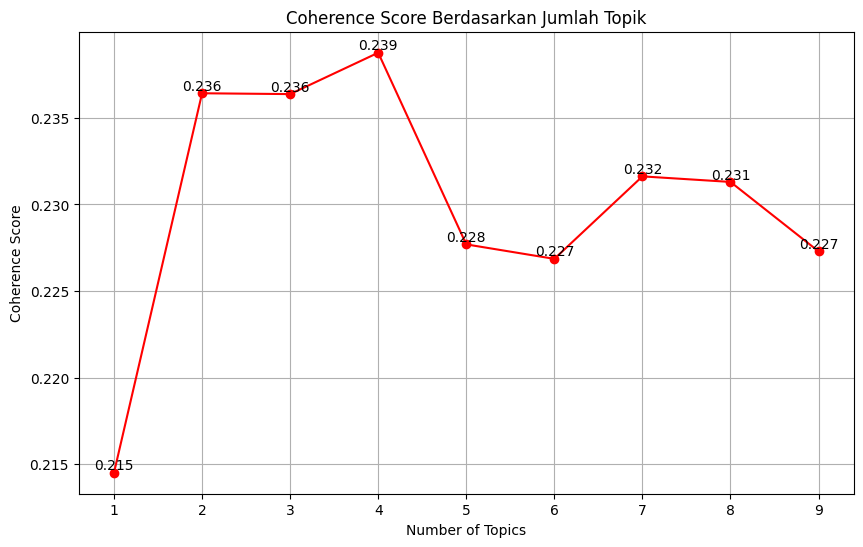

In [202]:
plt.figure(figsize=(10, 6))
plt.plot(range(1,10), coherence, marker='o', color='r')

for i in range(1,10):
    plt.text(i, coherence[i-1], f'{coherence[i-1]:.3f}', ha='center', va='bottom')

plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score Berdasarkan Jumlah Topik')
plt.grid(True)
plt.show()

In [203]:
docs[docs["Topic"]==0]

,Doc,Topic,Doc_ID
7,kasi bintang bentuk apresiasi pemerintah go di...,0,7
10,udah daftar akun kek login email verifikasi ke...,0,10
16,mudah daftarnyaloginnyameski sempet kebingunga...,0,16
19,puas sekalidengan aplikasi lihat keluarga terd...,0,19
33,kasih bintang biar akun sya buka ya akun aktiv...,0,33
...,...,...,...
8673,bermanfaat sekalimudah ribetcara regristrasiny...,0,8673
8675,aktivasi sabar org sibuk kali yahjdi lgi mmbtu...,0,8675
8687,tau biaya dikeluarkan pemerintah utk aplikasi ...,0,8687
8694,betol ajalah klen orang udah daftar usulan pas...,0,8694


In [204]:
sentimen['Topic'] = docs["Topic"].copy()
sentimen

,content,labeling,content_cleaned,Topic
0,Saya sudah daftar dan ter verifikasi udh menga...,0,daftar ter verifikasi udh mengajukan bantuan j...,2
1,Aku kasih bintang 5 krn aku belum pernah meras...,0,kasih bintang krn seumur hidup ngk bantuan ban...,2
2,Error Json Parse' padahal sudah update dan di ...,0,error json parse update coba berkali,1
3,Negara +62 yg PNS nya digaji SDM nya ga punya ...,0,negara pns digaji sdm ga kwalitas website data...,2
4,Aku harap pendataannya sesuai dengan target,1,harap pendataannya sesuai target,1
...,...,...,...,...
8699,"Aplikasi gag jelas..., udh nunggu approval nya...",0,aplikasi gag udh nunggu approval pas udah appr...,0
8700,"ga bisa login ""akun anda tidak di temukan /bel...",0,ga login akun temukan aktivasi aktivasinya gim...,2
8701,"Kenapa aplikasi erros terus, trus ditulisnya b...",0,aplikasi erros trus ditulisnya bilang laporan ...,3
8702,"Pendaftaran sangat di persulit, Data saya suda...",0,pendaftaran persulit data seseuai ktp berlaku ...,2


In [205]:
lis_topik = {}
for i in range(len(top_words)):
  lis_topik[i] = top_words[i]

In [206]:
df = sentimen[["labeling", "Topic"]].copy()
df

,labeling,Topic
0,0,2
1,0,2
2,0,1
3,0,2
4,1,1
...,...,...
8699,0,0
8700,0,2
8701,0,3
8702,0,2


In [207]:
df["labeling"].replace({0:"Negatif",1:"Positif"}, inplace=True)

In [208]:
df = df.sort_values(by=['Topic'], ascending=True)

In [209]:
for i in range(len(top_words)):
  df["Topic"].replace({i:f"Topik {i+1}"}, inplace=True)

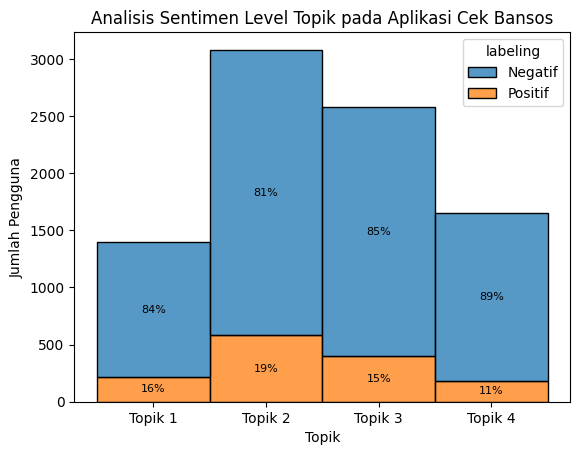

In [210]:
import pandas as pd
import seaborn as sns

ax = sns.histplot(df, x="Topic", hue='labeling', multiple='stack')
ax.set(title="Analisis Sentimen Level Topik pada Aplikasi Cek Bansos")
ax.set_ylabel("Jumlah Pengguna")
ax.set_xlabel("Topik")

for i, c in enumerate(ax.containers):
    # customize the label to account for cases when there might not be a bar section - with assignment expression (h := ...)
    panjang = []
    for i in range(len(top_words)):
      panjang.append(len(df[df["Topic"] == f"Topik {i+1}"]))
    labels = [f'{h:0.0f}' if (h := v.get_height()) > 0 else '' for v in c]
    lab = [int(label) for label in labels]
    per = []
    for i in range(len(top_words)):
      per.append(((lab[i]/panjang[i])*100))
    percent = [f'{h:0.0f}%' for h in per]
    ax.bar_label(c, labels=percent, label_type='center', fontsize=8)

plt.show()

In [211]:
df["Topic"].unique()

array(['Topik 1', 'Topik 2', 'Topik 3', 'Topik 4'], dtype=object)

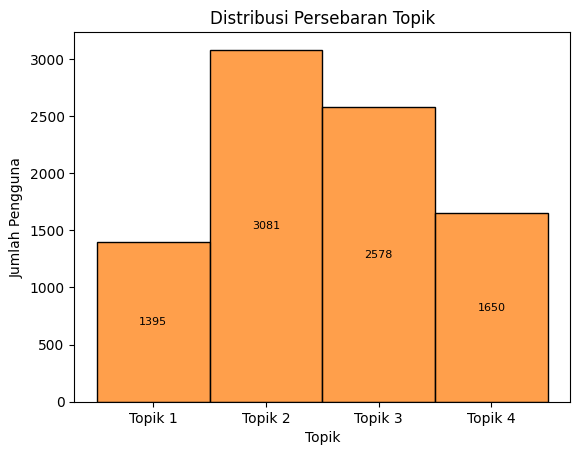

In [212]:
ax = sns.histplot(df, x="Topic", color='tab:orange')
ax.set(title="Distribusi Persebaran Topik")
ax.set_ylabel("Jumlah Pengguna")
ax.set_xlabel("Topik")

for i, c in enumerate(ax.containers):
    labels = [f'{h:0.0f}' if (h := v.get_height()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=8)